In [151]:
# Standard Imports
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pickle
import eli5

# Transformers
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

# Modeling Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, confusion_matrix, classification_report
from IPython.display import display, Markdown

# Pipelines
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as PipeImb
from imblearn.pipeline import make_pipeline


# Machine Learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier


#Validation methods
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedStratifiedKFold

#Sampling methods
from imblearn.over_sampling import SMOTENC


In [152]:
#Look at pipeline and what it does
# from sklearn import set_config
#set_config(display='diagram')
#display(search2)

# User defined functions

In [153]:
def a_xy_split(dataframe,y_name,test_size=.3):
   
    #Get xy split and train/test data ready
    X = dataframe.drop([y_name], axis=1)
    y = dataframe.attrition
    y = LabelEncoder().fit_transform(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,random_state=42)

    #Prep numerical and other column types for use in preprocessor
    numerical=X.select_dtypes(include='number')
    categorical=X.select_dtypes(include='object')
    numerical_columns=list(numerical.columns)
    categorical_columns=list(categorical.columns)
    columns=list(X.columns)
    cat_col_bool=[True if x in categorical_columns else False for x in columns]

    return X_train, X_test, y_train, y_test,numerical_columns,categorical_columns,cat_col_bool

In [154]:
def b_preprocessors():
    #Creating ss transformer to scale the continuous numerical data with StandardScaler()
    ss = Pipeline(steps=[('ss', StandardScaler())])
    #--------------------------------------------------------------------
    #Creating ohe transformer to encode the categorical data with OneHotEncoder()
    ohe = Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore', drop='first'))])
    #--------------------------------------------------------------------
    #Creating preprocess column transformer to combine the ss and ohe pipelines
    preprocess = ColumnTransformer(
                        transformers=[
                            ('num', ss, numerical_columns),
                            ('cat', ohe, categorical_columns)
                        ])
    return preprocess



In [155]:
def c_get_standard_params():
        #Creating parameter grid for Random Forest
        rand_forest_parms = {'classifier__n_estimators': [100, 300, 500],
                'classifier__max_depth':[6, 25, 50, 70],
                'classifier__min_samples_split': [2, 5, 10],
                'classifier__min_samples_leaf': [1, 2, 10]}
        
        decision_tree_params = {'classifier__max_depth':[6, 25, 50, 70],
                'classifier__min_samples_split': [2, 5, 10],
                'classifier__min_samples_leaf': [1, 2, 10],
                'classifier__max_features': [1,2,5,10]}

        xgb_params = { 'classifier__max_depth': [3,6,10],
                'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                'classifier__n_estimators': [100, 500, 1000],
                'classifier__colsample_bytree': [0.3, 0.7],
                'classifier__subsample':[.6,1]}

        log_regress_params={'classifier__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                        'classifier__penalty':['none','l1','l2','elasticnet'],
                        'classifier__C':[100,10,1.0, 0.1,0.01]}
        
        knn_params={'classifier__n_neighbors':[1, 5, 10],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__metric': ['euclidean', 'manhattan', 'minkowski']}

        gaussian_params={'classifier__var_smoothing': [1e-11, 1e-10, 1e-9]}

        bagging_params= {'classifier__base_estimator__max_depth' : [1, 2, 3, 4, 5],
        'classifier__max_samples' : [0.05, 0.1, 0.2, 0.5]}

        return rand_forest_parms,xgb_params,log_regress_params,knn_params,gaussian_params,bagging_params,decision_tree_params

In [156]:
def _evaluation(y, y_hat, title = 'Confusion Matrix'):
    cm = confusion_matrix(y, y_hat)
    precision = precision_score(y, y_hat)
    recall = recall_score(y, y_hat)
    accuracy = accuracy_score(y,y_hat)
    f1 = f1_score(y,y_hat)
    print('Accuracy: ', accuracy)
    print('Recall: ', recall)
    print('Precision: ', precision)
    print('F1: ', f1)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws=    {'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)
    
    plt.show()



# Stack formula

In [157]:
def _get_stacking():
    # define the base models
    level0 = list()
    level0.append(('bag',BaggingClassifier(base_estimator=LogisticRegression(max_iter=100,penalty='l1',solver='saga',warm_start=True,random_state=1234),n_estimators=15,bootstrap=True,warm_start=True,n_jobs=-1,random_state=1234)))
    #level0.append(('dt',DecisionTreeClassifier(max_depth= 6, max_features=1, min_samples_leaf= 2, min_samples_split= 10,random_state=1234)))
    #level0.append(('gau',GaussianNB()))
    #level0.append(('xgb', XGBClassifier()))
    #level0.append(('svm', SVC(random_state=42)))
    #level0.append(('lr', LogisticRegression(max_iter=100,penalty='l1',solver='saga',random_state=1234)))
    level0.append(('knn', KNeighborsClassifier(metric='manhattan',n_neighbors=10,weights='distance')))
    # define meta learner model
    level1 = LogisticRegression(random_state=1234)
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

In [158]:
def d_check_best_model(smote_type="nc"):
    stack=_get_stacking()
    models=[LogisticRegression(),RandomForestClassifier(),XGBClassifier(),KNeighborsClassifier(),DecisionTreeClassifier(),stack,SVC(),GaussianNB(),BaggingClassifier()]
    avg_acc=[]
    avg_rec=[]
    avg_prec=[]
    f1=[]
    for i in models:
        print (i)
        a,r,p,f=e_cross_validate_grid(preprocess,i,cv=KFold(),grid_search=False,smote_type=smote_type,check_best=True)
        avg_acc.append(a)
        avg_rec.append(r)
        avg_prec.append(p)
        f1.append(f)
        print()
    res_df=pd.DataFrame(columns=["model",'accuracy','recall','precision','f1'])
    res_df['model']=models
    res_df['accuracy']=avg_acc
    res_df['recall']=avg_rec
    res_df['precision']=avg_prec
    res_df['f1']=f1
    return res_df.sort_values(by="f1",ascending=False)

In [159]:
def e_cross_validate_grid(preprocessor, classifier, smote_type='NC', param_grid="none", cv="none", scoring="recall", conf_matrix=False, grid_search=False,check_best=False):
    cv = cv

    #Set correct pipeline for use in the formula
    pipeline = PipeImb(steps=[
    ('preprocess', preprocessor),
    ('classifier', classifier)])


    if smote_type.lower()=="nc":
        pipeline.steps.insert(0,('smote',SMOTENC(categorical_features=X_train.dtypes==object,random_state=1234,n_jobs=-1)))


    if grid_search==True:
        search = GridSearchCV(pipeline, param_grid=param_grid, cv=cv,scoring=scoring)
    else:
        search=pipeline
# Run train and validation methods, print average result for each
    train_acc = []
    train_rec=[]
    train_prec=[]
    test_acc = []
    test_rec=[]
    test_prec=[]
    for train_ind, val_ind in cv.split(X_train, y_train):
        X_t, y_t = X_train.iloc[train_ind], y_train[train_ind]
        search.fit(X_t, y_t)
        y_hat_t = search.predict(X_t)
        train_acc.append(accuracy_score(y_t, y_hat_t))
        train_rec.append(recall_score(y_t,y_hat_t))
        train_prec.append(precision_score(y_t,y_hat_t))
        X_val, y_val = X_train.iloc[val_ind], y_train[val_ind]
        y_hat_val = search.predict(X_val)
        test_acc.append(accuracy_score(y_val, y_hat_val))
        test_rec.append(recall_score(y_val, y_hat_val))
        test_prec.append(precision_score(y_val, y_hat_val))

    if conf_matrix==True:
        print("Validation set confusion matrix")
        print(_evaluation(y_val, y_hat_val))
        print()
    print('Avg Training Accuracy: {}'.format(np.mean(train_acc)))
    print("Avg Training Recall: {}".format(np.mean(train_rec)))
    print("Avg Training Precision: {}".format(np.mean(train_prec)))
    print()
    print('Avg Validation Accuracy: {}'.format(np.mean(test_acc)))
    print("Avg Validation Recall: {}".format(np.mean(test_rec)))
    print("Avg Validation Precision: {}".format(np.mean(test_prec)))
    print()

# If grid search used, print best estimator's features
    if (grid_search==True):
        ohe_cols = list(search.best_estimator_.named_steps['preprocess'].named_transformers_['cat'].named_steps['ohe'].get_feature_names_out(
        input_features=categorical_columns))
        num_feats = list(numerical_columns)
        num_feats.extend(ohe_cols)
        feat_imp = eli5.explain_weights_df(search.best_estimator_.named_steps['classifier'], top=10, feature_names=num_feats)
        print(feat_imp)
        print()
        print('Grid Search Best Params:')
        print()
        print(search.best_params_)
    if check_best==True:
        acc= np.mean(test_acc)
        rec=np.mean(test_rec)
        prec=np.mean(test_prec)
        f1=2*(prec*rec)/(prec+rec)

        return acc,rec,prec,f1
    else:
        return search


In [160]:
def g_validate_using_test(preprocessor, classifier, grid, cv):
    final_pipeline = GridSearchCV(PipeImb(steps=[
            ('preprocess', preprocessor),
            ('classifier', classifier)
        ]), grid, cv=cv)
    #Fit and predict on train data
    final_pipeline.fit(X_train, y_train)

    train_pred = final_pipeline.best_estimator_.predict(X_train)
    #train_pred=final_pipeline.predict(X_train)

    print('Evaluation on training data \n')
    print(_evaluation(y_train, train_pred))
    print('\n')
    #Predict on test data

    test_pred = final_pipeline.best_estimator_.predict(X_test)
    #test_pred = final_pipeline.predict(X_test)
    print('Evaluation on testing data \n')
    print(_evaluation(y_test, test_pred))

In [161]:
def f_validate_pipeline_on_test(pipeline):
    test_pred = pipeline.predict(X_test)
    #test_pred = final_pipeline.predict(X_test)
    print('Evaluation on testing data \n')
    print(_evaluation(y_test, test_pred))

# Code here

In [162]:
df=pd.read_csv(r"Data\4b.IBM_data_cleaned_dropped - Copy - Copy.csv")
df2=df[df['age']<42].copy()
df3=df2[df2['jobrole'].isin(['laboratory technician','sales representative'])].copy()

In [163]:
#df3['workbeforecompany']=df3['totalworkingyears']-df3['yearsatcompany']
#df3['engagement']=((df3['worklifebalance']+df3['jobinvolvement']+df3['environmentsatisfaction']+df3['jobsatisfaction'])/4)
#df3['embedded']=df3['stockoptionlevel']*df3['totalworkingyears']*df3['salaryquartile']*df3['yearsatcompany']
#df3.drop(columns=['businesstravel','educationfield','gender','percentsalaryhike','yearswithcurrmanager','yearssincelastpromotion','trainingtimeslastyear'],axis=1,inplace=True)

In [164]:
y_name='attrition'
X_train, X_test, y_train, y_test,numerical_columns,categorical_columns,cat_col_bool=a_xy_split(df2,y_name,test_size=.3)
#X_train, X_test, y_train, y_test,numerical_columns,categorical_columns,cat_col_bool=a_xy_split(df2,y_name,test_size=.2)
preprocess=b_preprocessors()
rand_forest_parms,xgb_params,log_regress_params,knn_params,gaussian_params,bagging_params,decision_tree_params=c_get_standard_params()
stack=_get_stacking()

In [201]:
d_check_best_model()

LogisticRegression()
Avg Training Accuracy: 0.8652505561409672
Avg Training Recall: 0.7093397085124342
Avg Training Precision: 0.6379918892753117

Avg Validation Accuracy: 0.8303513186096356
Avg Validation Recall: 0.6435675618411991
Avg Validation Precision: 0.5520904335420465


RandomForestClassifier()
Avg Training Accuracy: 1.0
Avg Training Recall: 1.0
Avg Training Precision: 1.0

Avg Validation Accuracy: 0.8344515888547199
Avg Validation Recall: 0.4818185285237565
Avg Validation Precision: 0.5976389552476509


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
    

,model,accuracy,recall,precision,f1
0,LogisticRegression(),0.830351,0.643568,0.552090,0.594330
5,"StackingClassifier(cv=5,\n e...",0.844003,0.529769,0.627080,0.574332
6,SVC(),0.835821,0.533555,0.592015,0.561267
2,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.830370,0.503350,0.585892,0.541493
1,"(DecisionTreeClassifier(max_features='auto', r...",0.834452,0.481819,0.597639,0.533515
3,KNeighborsClassifier(),0.779722,0.587133,0.449896,0.509434
8,(DecisionTreeClassifier(random_state=305674899...,0.813913,0.421468,0.529445,0.469326
4,DecisionTreeClassifier(),0.734601,0.452482,0.351122,0.395409
7,GaussianNB(),0.395285,0.893300,0.229375,0.365023


# Stack option

In [166]:
pipeline_stack=e_cross_validate_grid(preprocess,stack,scoring='recall', cv=KFold(),grid_search=False,conf_matrix=False)

Avg Training Accuracy: 1.0
Avg Training Recall: 1.0
Avg Training Precision: 1.0

Avg Validation Accuracy: 0.8440033547665642
Avg Validation Recall: 0.5297693733778271
Avg Validation Precision: 0.6270797299762817



Evaluation on testing data 

Accuracy:  0.8503184713375797
Recall:  0.4897959183673469
Precision:  0.5217391304347826
F1:  0.5052631578947369


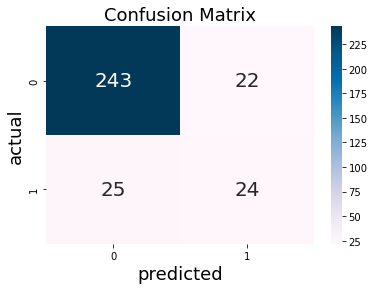

None


In [167]:
f_validate_pipeline_on_test(pipeline_stack)

# Log Regression only

In [168]:
pipeline_log=e_cross_validate_grid(preprocess,LogisticRegression(random_state=1234),scoring='recall', cv=KFold(),grid_search=False,conf_matrix=False)

Avg Training Accuracy: 0.8652505561409672
Avg Training Recall: 0.7093397085124342
Avg Training Precision: 0.6379918892753117

Avg Validation Accuracy: 0.8303513186096356
Avg Validation Recall: 0.6435675618411991
Avg Validation Precision: 0.5520904335420465



Evaluation on testing data 

Accuracy:  0.8662420382165605
Recall:  0.673469387755102
Precision:  0.559322033898305
F1:  0.611111111111111


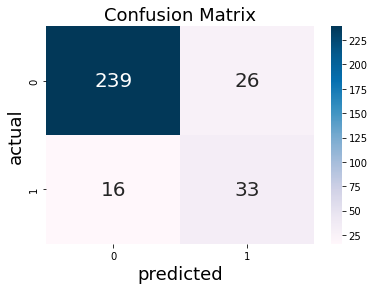

None


In [169]:
f_validate_pipeline_on_test(pipeline_log)

# Bag KNN

Validation set confusion matrix
Accuracy:  0.815068493150685
Recall:  0.6111111111111112
Precision:  0.6285714285714286
F1:  0.619718309859155


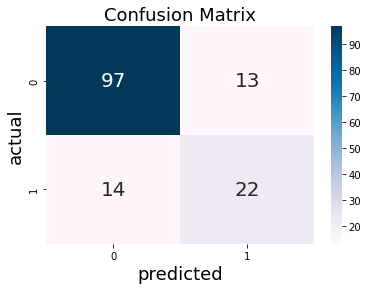

None

Avg Training Accuracy: 0.9958968504858916
Avg Training Recall: 0.994835903926813
Avg Training Precision: 0.984192564662784

Avg Validation Accuracy: 0.8002422886963005
Avg Validation Recall: 0.5733397602274132
Avg Validation Precision: 0.4890341451631774



In [170]:
pipeline_bag_knn=e_cross_validate_grid(preprocess,BaggingClassifier(base_estimator=KNeighborsClassifier(metric='manhattan',n_neighbors=10,weights='distance')),scoring='recall', cv=KFold(),param_grid=knn_params,grid_search=False,conf_matrix=True)

Evaluation on testing data 

Accuracy:  0.7643312101910829
Recall:  0.5102040816326531
Precision:  0.3333333333333333
F1:  0.4032258064516129


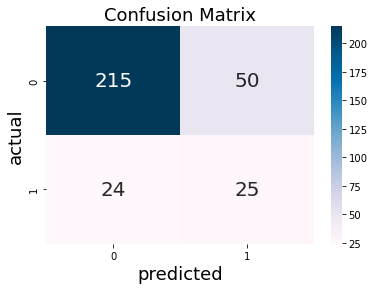

None


In [171]:
f_validate_pipeline_on_test(pipeline_bag_knn)

# Bag LR

c:\Users\MichaelTaylo_c9zoof3\anaconda3\envs\DA_Env\lib\site-packages\sklearn\ensemble\_bagging.py:374: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(
c:\Users\MichaelTaylo_c9zoof3\anaconda3\envs\DA_Env\lib\site-packages\sklearn\ensemble\_bagging.py:374: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(
c:\Users\MichaelTaylo_c9zoof3\anaconda3\envs\DA_Env\lib\site-packages\sklearn\ensemble\_bagging.py:374: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


Validation set confusion matrix
Accuracy:  0.8698630136986302
Recall:  0.75
Precision:  0.7297297297297297
F1:  0.7397260273972601


c:\Users\MichaelTaylo_c9zoof3\anaconda3\envs\DA_Env\lib\site-packages\sklearn\ensemble\_bagging.py:374: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


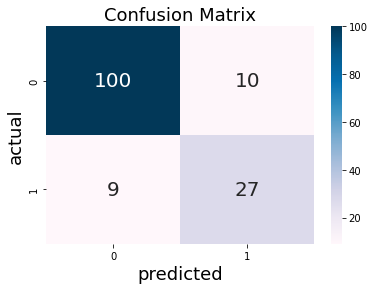

None

Avg Training Accuracy: 0.8515747570542092
Avg Training Recall: 0.7428344535875008
Avg Training Precision: 0.5941603428145518

Avg Validation Accuracy: 0.8467803559780076
Avg Validation Recall: 0.7441916415064357
Avg Validation Precision: 0.5836829354786011



In [172]:
#One of better predictors
pipeline_bag_lr=e_cross_validate_grid(preprocess,BaggingClassifier(base_estimator=LogisticRegression(max_iter=100,penalty='l1',solver='saga',warm_start=True),n_estimators=10,bootstrap=True,warm_start=True,n_jobs=-1),scoring='recall', cv=KFold(),param_grid=knn_params,grid_search=False,conf_matrix=True)

Evaluation on testing data 

Accuracy:  0.8694267515923567
Recall:  0.7142857142857143
Precision:  0.5645161290322581
F1:  0.6306306306306306


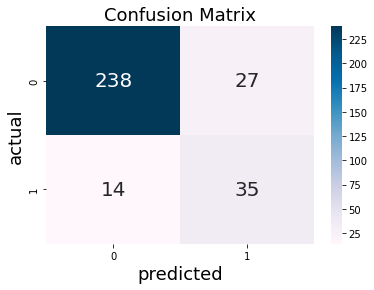

None


In [173]:
f_validate_pipeline_on_test(pipeline_bag_lr)

# Bag LR best so far


c:\Users\MichaelTaylo_c9zoof3\anaconda3\envs\DA_Env\lib\site-packages\sklearn\ensemble\_bagging.py:374: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(
c:\Users\MichaelTaylo_c9zoof3\anaconda3\envs\DA_Env\lib\site-packages\sklearn\ensemble\_bagging.py:374: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(
c:\Users\MichaelTaylo_c9zoof3\anaconda3\envs\DA_Env\lib\site-packages\sklearn\ensemble\_bagging.py:374: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


Validation set confusion matrix
Accuracy:  0.863013698630137
Recall:  0.6944444444444444
Precision:  0.7352941176470589
F1:  0.7142857142857144


c:\Users\MichaelTaylo_c9zoof3\anaconda3\envs\DA_Env\lib\site-packages\sklearn\ensemble\_bagging.py:374: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


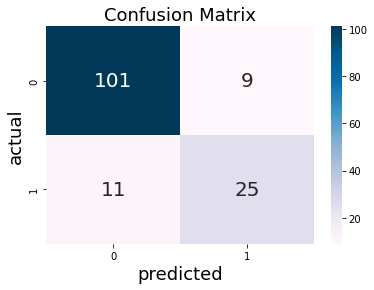

None

Avg Training Accuracy: 0.8529446200679077
Avg Training Recall: 0.7255509058132048
Avg Training Precision: 0.6006794158557083

Avg Validation Accuracy: 0.8508899450191036
Avg Validation Recall: 0.7335254692162367
Avg Validation Precision: 0.5986104298178601

Evaluation on testing data 

Accuracy:  0.8726114649681529
Recall:  0.7142857142857143
Precision:  0.5737704918032787
F1:  0.6363636363636364


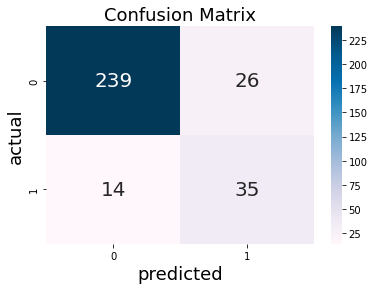

None


In [174]:
#One of better predictors
pipeline_bag_lr2=e_cross_validate_grid(preprocess,BaggingClassifier(base_estimator=LogisticRegression(max_iter=100,penalty='l1',solver='saga',warm_start=True,random_state=1234),n_estimators=15,bootstrap=True,warm_start=True,n_jobs=-1,random_state=1234),scoring='recall', cv=KFold(),param_grid=knn_params,grid_search=False,conf_matrix=True)
f_validate_pipeline_on_test(pipeline_bag_lr2)

In [186]:
df5=df2.copy()
df5.drop(columns='attrition',axis=1,inplace=True)

In [187]:
leave=pipeline_bag_lr2.predict_proba(df5)

In [188]:
len(leave)

1045

In [189]:
df2['stay_prob']=leave[:,0]

In [191]:
df2.to_csv("Data\leave_chance.csv")

# VotingClassifier

In [299]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
clf1=LogisticRegression(random_state=1234)
clf2=stack
clf3=SVC(probability=True,random_state=1324)
clf4=BaggingClassifier(base_estimator=LogisticRegression(max_iter=100,penalty='l1',solver='saga',warm_start=True,random_state=1234),n_estimators=15,bootstrap=True,warm_start=True,n_jobs=-1,random_state=1234)
clf5=XGBClassifier()
clf7=GaussianNB()
clf6=DecisionTreeClassifier(max_depth= 6, max_features=1, min_samples_leaf= 2, min_samples_split= 10,random_state=1234)
weght=[100,30,40]
est=[('bag',clf4),('svc',clf3),('stack',clf2)]
vote_c3=VotingClassifier(estimators=est,weights=weght,voting='soft',n_jobs=-1)
vote_c4=VotingClassifier(estimators=est,voting='hard',weights=weght)



Avg Training Accuracy: 0.9394649338484955
Avg Training Recall: 0.8345652453638307
Avg Training Precision: 0.8514791688112882

Avg Validation Accuracy: 0.8440126735625757
Avg Validation Recall: 0.6215527305471689
Avg Validation Precision: 0.5999222999223

Evaluation on testing data 

Accuracy:  0.8789808917197452
Recall:  0.6530612244897959
Precision:  0.6037735849056604
F1:  0.6274509803921567


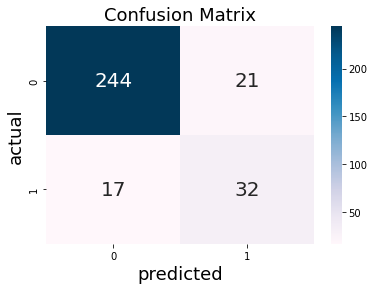

None


In [300]:
pipeline_vote2=e_cross_validate_grid(preprocess,vote_c3,scoring='recall', cv=KFold(),param_grid=knn_params,grid_search=False,conf_matrix=False)
f_validate_pipeline_on_test(pipeline_vote2)

In [ ]:
KNeighborsClassifier(n_jobs=)